In [96]:
# importing model and libraries
from darts.models import BlockRNNModel, TiDEModel
from darts import TimeSeries
from darts.dataprocessing.transformers.scaler import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.metrics import mae, mse
import torch
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

df = pd.read_csv('ewz_stromabgabe_netzebenen_stadt_zuerich.csv')
df.head()

,Timestamp,Value_NE5,Value_NE7
0,2015-01-01T00:15:00+01:00,22009.8441,46078.667617
1,2015-01-01T00:30:00+01:00,21809.9232,45160.698223
2,2015-01-01T00:45:00+01:00,21854.9834,44388.693804
3,2015-01-01T01:00:00+01:00,21975.9378,44062.418421
4,2015-01-01T01:15:00+01:00,22197.9830,43462.381814


In [97]:
# Convert 'Timestamp' to datetime and set it as the index
df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True).dt.tz_localize(None)
df.set_index('Timestamp', inplace=True)

# Preserve the 'Timestamp [ms]' column

# Resample the time series to 1-hour frequency
df = df.resample('1H').mean()

df['Timestamp'] = df.index

df.head()


,Value_NE5,Value_NE7,Timestamp
Timestamp,,,
2014-12-31 23:00:00,21891.583567,45209.353215,2014-12-31 23:00:00
2015-01-01 00:00:00,22186.897125,43185.687737,2015-01-01 00:00:00
2015-01-01 01:00:00,21716.133025,43385.300049,2015-01-01 01:00:00
2015-01-01 02:00:00,21039.683475,40700.715810,2015-01-01 02:00:00
2015-01-01 03:00:00,20283.326025,38530.878445,2015-01-01 03:00:00


In [98]:
# Create a Darts TimeSeries object
series = TimeSeries.from_dataframe(df, 'Timestamp', 'Value_NE5')

# Assuming 'series' is your TimeSeries object
train_size = int(len(series) * 0.1)  # Halve the training set

# Split the data
series = series[train_size:]

<Axes: xlabel='Timestamp'>

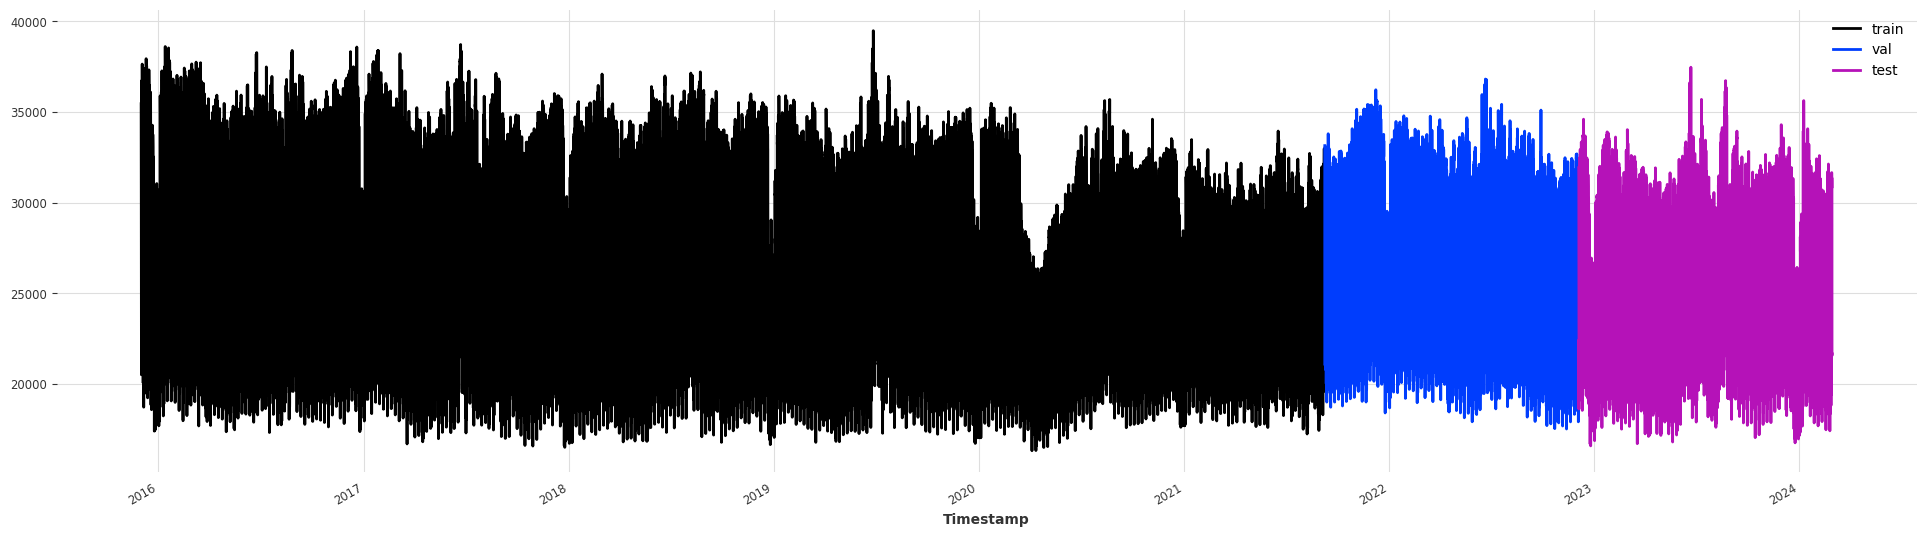

In [99]:
train, temp = series.split_after(0.7)
val, test = temp.split_after(0.5)

plt.figure(figsize=(24, 6))
train.plot(label="train")
val.plot(label="val")
test.plot(label="test")

<Axes: xlabel='Timestamp'>

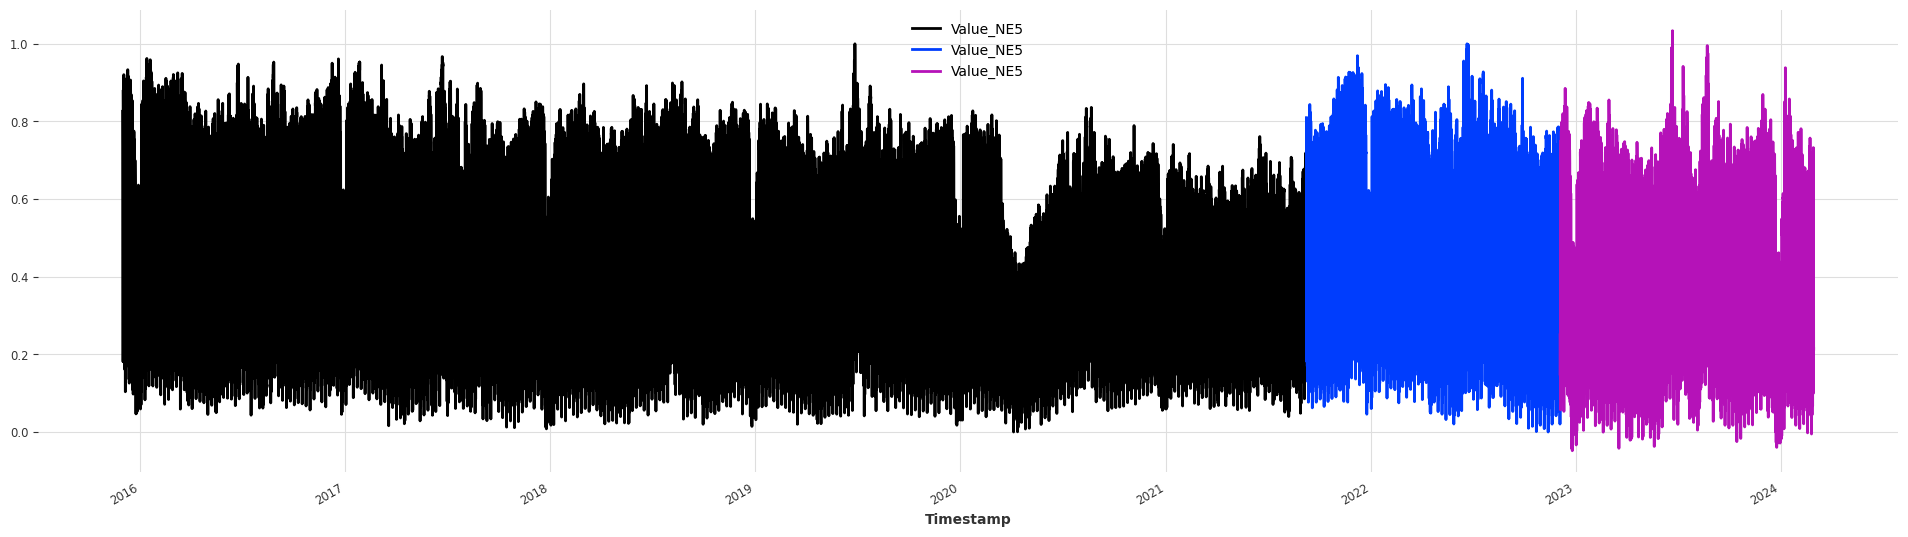

In [100]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
val = scaler.fit_transform(val)
test = scaler.transform(test)

plt.figure(figsize=(24, 6))
train.plot()
val.plot()
test.plot()

In [101]:
common_model_args = {
    "input_chunk_length": 512,
    "output_chunk_length": 256,
    "optimizer_kwargs": {"lr": 1e-3},
    "pl_trainer_kwargs": {
        "gradient_clip_val": 1,
        "max_epochs": 10,
        "accelerator": "auto",
        "callbacks": [],
        "logger": None
    },
    "lr_scheduler_cls": torch.optim.lr_scheduler.ExponentialLR,
    "lr_scheduler_kwargs": {"gamma": 0.999},
    "likelihood": None,
    "save_checkpoints": True,
    "force_reset": True,
    "batch_size": 128,
    "random_state": 42,
}

# Define early stopping arguments
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 3,
    "mode": "min",
    "strict": True,
    "verbose": True,
}

model_rnn_params = {
    "model_name": "rnn",
    "model": "RNN",
    "n_rnn_layers": 6
}

model_tide_params = {
    "model_name": "tide",
    "use_reversible_instance_norm": False,
}

model_rnn = BlockRNNModel(**common_model_args, **model_rnn_params)
model_tide = TiDEModel(**common_model_args, **model_tide_params)


models = {
    "RNN": model_rnn,
    #"TiDE": model_tide,
}

In [108]:
import pickle

# Set the log directory where logs will be saved
log_dir = "logs"

# Create a TensorBoardLogger
logger = TensorBoardLogger(log_dir, name="bitbrains_all_models")

# Update your pl_trainer_kwargs
common_model_args['pl_trainer_kwargs']["logger"] = logger

for name, model in models.items():
    # early stopping needs to get reset for each model
    common_model_args['pl_trainer_kwargs']["callbacks"] = [
        EarlyStopping(
            **early_stopping_args,
        )
    ]

    pl_trainer = pl.Trainer(**common_model_args['pl_trainer_kwargs'])

    model.fit(
        series=train,
        val_series=val,
        verbose=True,
    )
    model.save(f"models/RNN_electricity.pt")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                    | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Timestamp'>

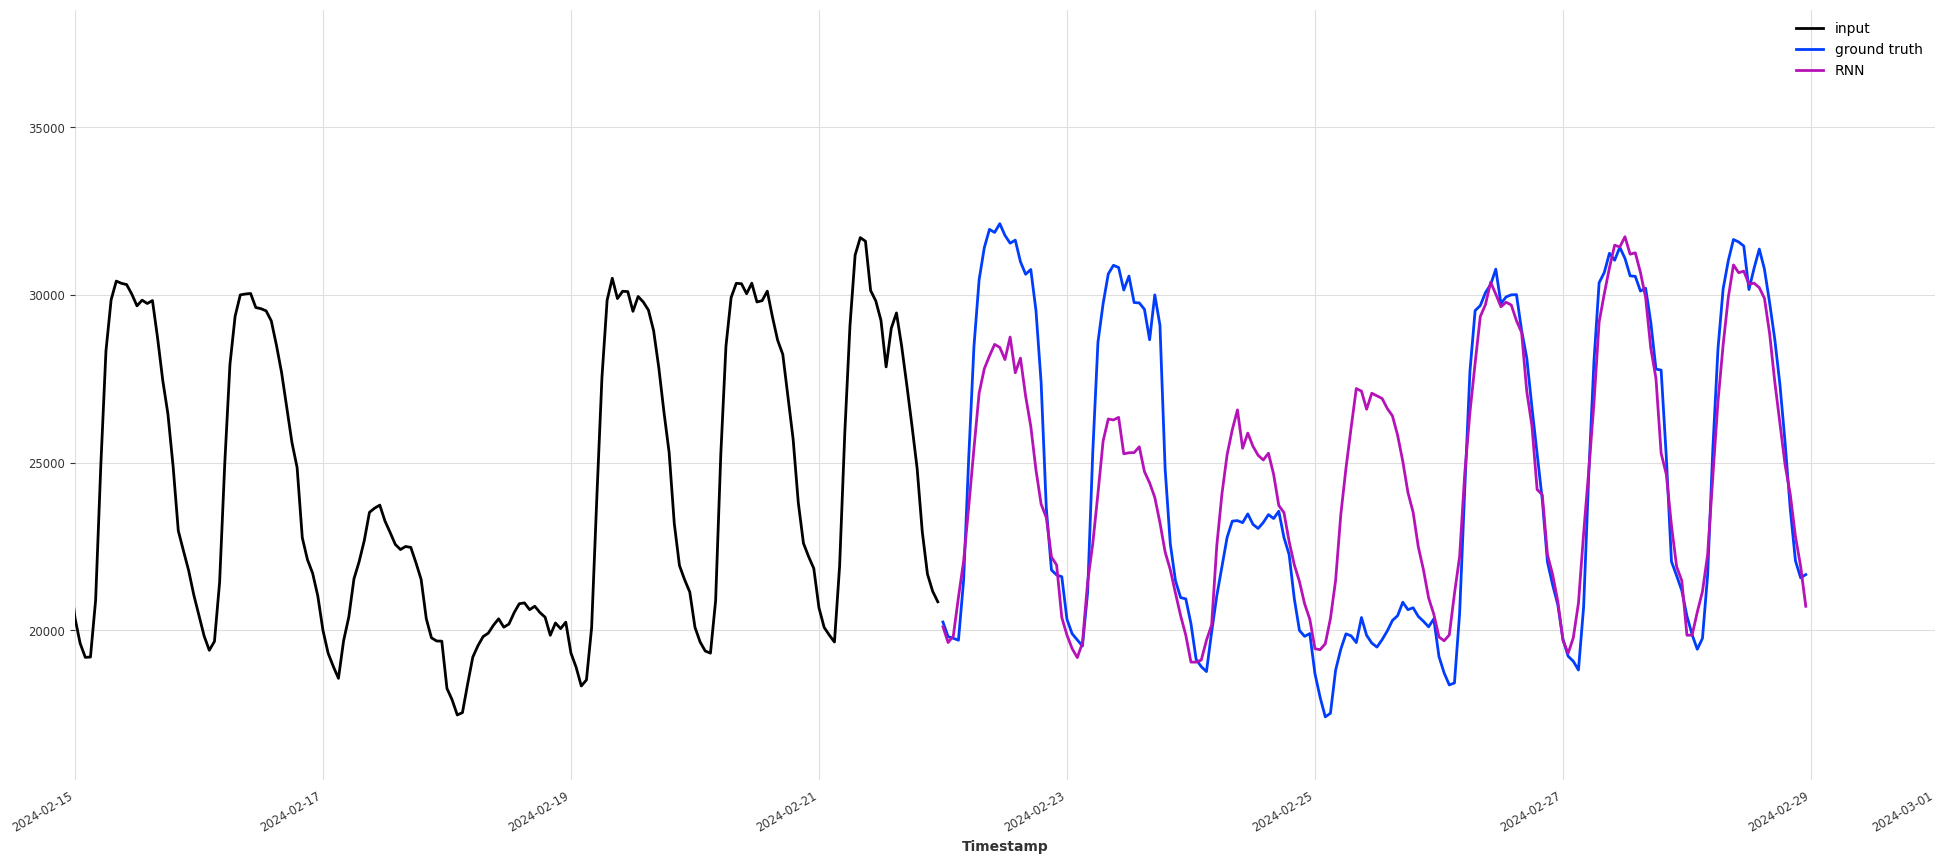

In [115]:
from darts.metrics import quantile_loss

# we will predict the next `pred_steps` points after the end of `pred_input`
pred_steps = 168
pred_input = test[:-pred_steps]

# Set the specific start date
start_date = pd.Timestamp("2024-02-15")
end_date = pd.Timestamp("2024-03-01")

fig, ax = plt.subplots(figsize=(24, 10))
plt.xlim(start_date, end_date)

scaler.inverse_transform(pred_input).plot(label="input")
scaler.inverse_transform(test)[-pred_steps:].plot(label="ground truth", ax=ax)

pred_series = model.predict(n=pred_steps, series=pred_input)
scaler.inverse_transform(pred_series).plot(label='RNN', ax=ax)

In [ ]:
import pickle
model.save(f"models/rnn_electricity.pt")